In [1]:

import importlib
import proshestic_processor.prosthetic_hand_data_processor as prosthetic_hand_data_processor
importlib.reload(prosthetic_hand_data_processor)

from proshestic_processor.prosthetic_hand_data_processor import ProstheticHandDataProcessor

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import lightgbm as lgb

import optuna



f:\Learnings\Motorika\Baseline\motorica-x-skillfactory-gestures\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Создаем df на базе считанных данных о файлах данных пилотов
pilot_files = pd.read_csv('./data/meta_information.csv')
# выбираем файлы для указанного пилота
pilote_id = 4
# создаем список файлов, котносящихся к указанному пилоту
palm_file = pilot_files[pilot_files.pilote_id == pilote_id].montage.apply(lambda x: './data/'+x).tolist()
# palm_file = './data/2023-06-05_16-12-38.palm'

In [3]:
# Создаем обьект на основе класса ProstheticHandDataProcessor
processor = ProstheticHandDataProcessor(
                              palm_file, # Список файлов с данными
                              pilote_id = pilote_id,# id пилота 
                              n_omg_channels=50, # количество каналов данных в файле
                              n_acc_channels=3, # количество каналов акселометра
                              n_gyr_channels=3, # количество каналов гироскопа
                              n_enc_channels=6, # количество кодированных каналов
                              n_mag_channels=0)

Всего файлов:                            7
Чтение файла значений:                   ./data/2023-05-15_16-16-08.palm
Чтение файла протокола жестов:           ./data/2023-05-15_16-16-08.palm
Количество записей:                      29145
Срезаем с и до:                          393 <> 29120
----------------------------------------------------------------------------------------------------
Чтение файла значений:                   ./data/2023-05-15_17-12-24.palm
Чтение файла протокола жестов:           ./data/2023-05-15_17-12-24.palm
Количество записей:                      29137
Срезаем с и до:                          395 <> 29109
----------------------------------------------------------------------------------------------------
Чтение файла значений:                   ./data/2023-06-05_16-12-38.palm
Чтение файла протокола жестов:           ./data/2023-06-05_16-12-38.palm
Количество записей:                      22368
Срезаем с и до:                          292 <> 22356
--------------

## Рабочий процесс создания данных для модели. Вариант 2

Для начала проанаизируем данные пилота с номеро 4, так как о нем у нас есть только 1 файл замеров и это немного отличается от других пилотов, где замеров больше и они часто координально отличаются друг от друга

Автоматизируем процесс обработки данных пилота и выбора сильных признаков.
* На основе данных о косинусном сходстве, выбираем сильные признаки.
* На каждом шаге убираем самый слабый признак
В итоге получаем и записываем статистику каждой из построенной модели

В итоге смотрим, при каком кол-ве признаков и каких признаках, модель была наилучшей для указанного пилота

In [6]:
processor.vectors_cousine()
steps = processor.get_cosine_steps(15)[:-3]
steps

Создание словаря с векторами в формате [сенсор][жест][шаг][значения], доступен через <object>.vectors 
Расчет косинусного сходства между векторами, сгруппированными по сенсорам, доступны через <object>.vectors_sum 
Создадим дополнительные признаки, путем ссумирования подряд по 5 сенсоров
Доступны через <object>.additional_features_1
 
Создадим векторы на базе additional_features_1 и интерполируем их
Доступны через <object>.additional_features_1_vector
 
Рассчитаем косинусную схожесть на векторе additional_features_1_vector
Доступны через <object>.additional_features_1_cosine_mean
 


[0.9905319180489384,
 0.9925627066156896,
 0.9951980959448136,
 0.9955254149945446,
 0.9963504471641859,
 0.9969451175154417,
 0.9970201301831263,
 0.9970666606587495,
 0.9982768790213704,
 0.9983578304922849,
 0.9991275901734709]

Создадим параметры отбора признаков и параметры модели для первичного обучения модели

In [6]:
selection_params = {
    'cosine' : 0,
    'sensor_power' : 25,
    'cosine_add_feature_1' : .9962329743225542,
    'shift' : (0,0)
}

lgb_params = {
    'n_estimators' : 1000,         # Количество деревьев
    'learning_rate' : 0.02,         # Скорость обучения
    'max_depth' : -1,              # Максимальная глубина деревьев (по умолчанию нет ограничений)
    'min_child_samples' : 20,      # Минимальное число образцов в листьях
    'subsample' : 0.8,             # Доля выборки для обучения каждого дерева
    'random_state' : 42            # Для воспроизводимости
}

rf_params = {
    'n_estimators': 50,          # Количество деревьев
    'max_depth': 40,             # Ограничение глубины деревьев
    'min_samples_split': 5,      # Минимум 5 выборок для разделения
    'min_samples_leaf': 3,       # Минимум 3 выборки в листе
    'max_features': 'log2',      # Количество признаков для каждого разделения
    'random_state': 42
}


### Процесс моделирования с разным набором признаков

Выберем несколько дополнительно синтезированных признаков и обучим модель random forest с учетом изменения количества признаков по размеру косинусного сходства

In [5]:
steps_additional_1 = processor.additional_features_1_cosine_mean

In [7]:
steps_add = sorted(steps_additional_1.values())[-4:]

In [21]:
for steps_a in steps_add:
    for step in steps:
        selection_params['cosine'] = step
        selection_params['cosine_add_feature_1'] = steps_a
        processor.fit_and_predict(pilote_id, 'rf', rf_params, selection_params, use_add=False, stat_file = 'st.json' )

    for step in steps:
        selection_params['cosine'] = step
        selection_params['cosine_add_feature_1'] = steps_a
        processor.fit_and_predict(pilote_id, 'rf', rf_params, selection_params, use_add=True, stat_file = 'st.json' )    


Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '16', '21', '22', '27', '28', '30', '38', '39']
['new_feature_1', 'new_feature_3', 'new_feature_7']
Новый объект добавлен успешно.
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '16', '21', '22', '27', '30', '38', '39']
['new_feature_1', 'new_feature_3', 'new_feature_7']
Новый объект добавлен успешно.
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '16', '21', '22', '30', '38', '39']
['new_feature_1', 'new_feature_3', 'new_feature_7']
Новый объект добавлен успешно.
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '16', '21', '22', '30', '39']
['new_feature_1', 'new_feature_3', 'new_feature_7']
Новый объект добавлен успешно.
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '21', '22', '30', '39']
['new_feature_1', 'new_feature_3', 'new_feature_7']
Новый объект добавлен успешно.
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '22

### Получение статистики

Получение данных их файла статистики, о лучшей и худшей моделях для Random Forest алгоритма и LGB

In [5]:
print(f'''ID пилота: {pilote_id}''')
model_stat = processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)
model_stat


ID пилота: 4


{'lgb': {'min': 0.9834158850537036,
  'min_id': 217,
  'max': 0.9935855615740742,
  'max_id': 73},
 'rf': {'min': 0.9688166372907409,
  'min_id': 66,
  'max': 0.9834577211611112,
  'max_id': 56}}

Просмотр деталей статистики для лучшей модели для random Forest алгоритма

In [6]:
max_rf = model_stat['rf']['max_id']
max_rf_value = model_stat['rf']['max']
processor.get_statistic_by_id(pd.read_json('st.json'),max_rf)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      0.992     0.976     0.989      0.998     0.989     0.997   
Open         0.999     1.000     1.000      0.990     0.958     0.984   
Pistol       0.999     0.981     0.996      0.987     0.968     0.983   
Thumb        0.994     0.980     0.991      0.982     0.952     0.975   
OK           0.998     0.970     0.993      0.988     0.944     0.979   
Grab         0.996     0.959     0.988      0.989     0.959     0.983   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      0.995     0.982     0.993  
Open         0.995     0.979     0.992  
Pistol       0.993     0.974     0.989  
Thumb        0.988     0.966     0.983  
OK           0.993     0.956     0.986  
Grab         0.993     0.959     0.986

Теперь, подобрав лучший набор признаков для модели, можем получить из файла статистики, при аких параметрах, данная модель была создана и далее попытаться настроить гиперпараметры для получения лучшего результата.

In [7]:
# прочтем файл статистики
stat = processor.get_stat('st.json')
best_model_params = processor.get_model_params_by_id(stat, max_rf)
best_params = processor.get_params_by_id(stat, max_rf)

In [8]:
# параметры модели, можем отталкиваться от них при настройке гиперпараметров
best_model_params

{'rf': {'n_estimators': 100,
  'max_depth': 40,
  'min_samples_split': 5,
  'min_samples_leaf': 3,
  'max_features': 'log2',
  'random_state': 42}}

In [9]:
# данные отбора признаков
best_params

{'cosine': 0.990531918048938,
 'sensor_power': 25,
 'cosine_add_feature_1': 0.999,
 'use_add': False,
 'shift': <bound method NDFrame.shift of cosine                   0.991
 sensor_power                25
 cosine_add_feature_1     0.999
 use_add                  False
 shift                   [0, 0]
 features_num                14
 features_add_1_num           0
 Name: 56, dtype: object>,
 'features_num': 14,
 'features_add_1_num': 0}

## Рабочий процесс создания данных для модели. Вариант 1

Строим модель на основе данных статистики и будем пытаться получить лучшие параметры для модели

In [10]:
# Инициализируем основные данные для текущей модели
processor.vectors_cousine()

# Применяем паарметры отбора для данных
processor.change_params_and_apply(best_params['cosine'],best_params['sensor_power'],best_params['cosine_add_feature_1'],(0,0))

# Получаем данные для обучения модели
X,X_init,y = processor.model_data_prepare(best_params['use_add'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Создание словаря с векторами в формате [сенсор][жест][шаг][значения], доступен через <object>.vectors 
Расчет косинусного сходства между векторами, сгруппированными по сенсорам, доступны через <object>.vectors_sum 
Создадим дополнительные признаки, путем ссумирования подряд по 5 сенсоров
Доступны через <object>.additional_features_1
 
Создадим векторы на базе additional_features_1 и интерполируем их
Доступны через <object>.additional_features_1_vector
 
Рассчитаем косинусную схожесть на векторе additional_features_1_vector
Доступны через <object>.additional_features_1_cosine_mean
 
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '16', '17', '21', '22', '27', '28', '30', '38', '39']
[]


### Давайте посмотрим на графике, какие входные данные мы имеем по каждому из каналов

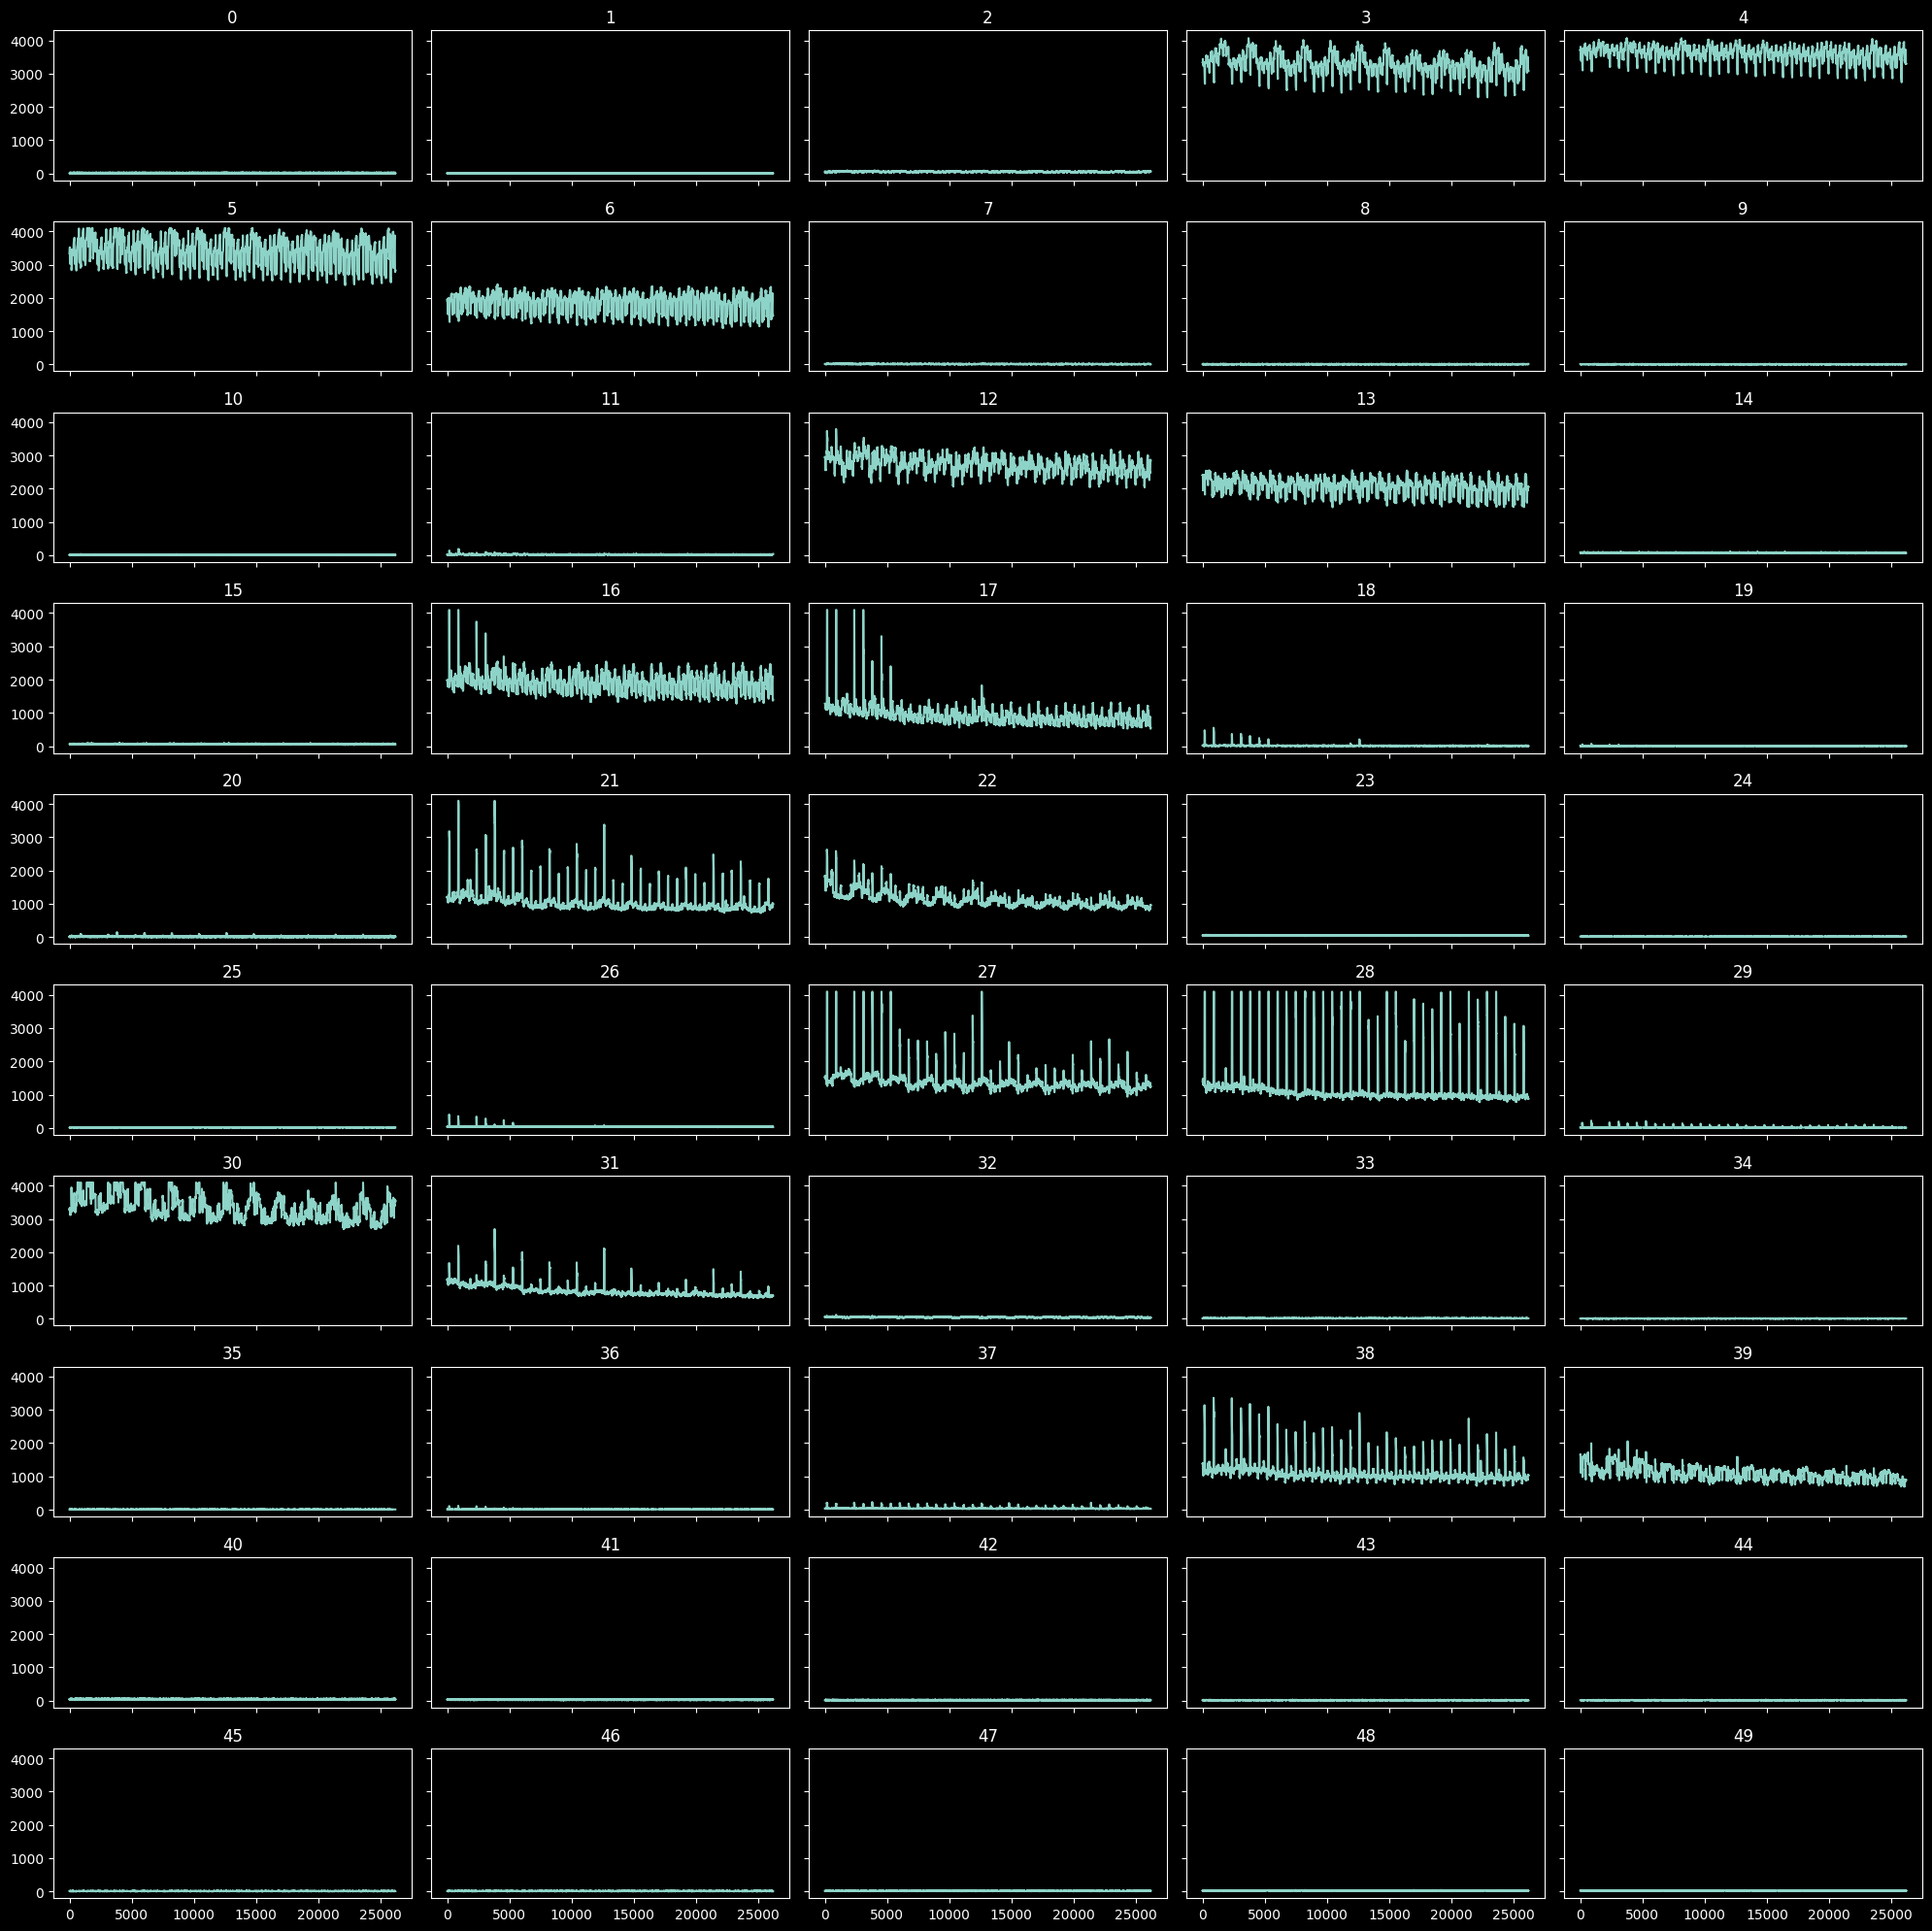

In [15]:
processor.plot_sensors(processor.OMG_CH, range(processor.gestures.shape[0]))

### Какие сенсоры алгортим отобрал для последующего обучения модели

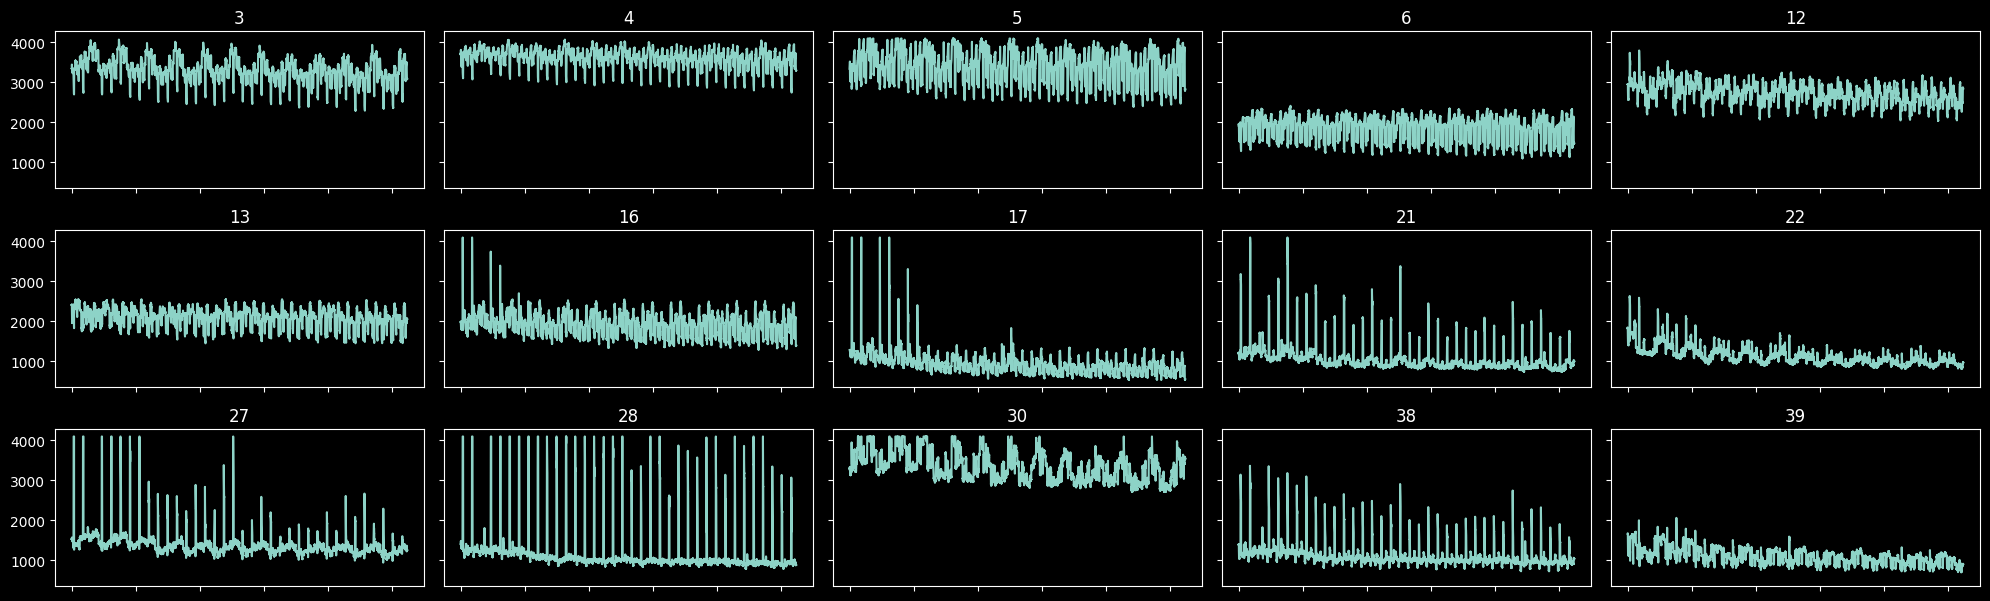

In [16]:
processor.plot_sensors(processor.CLEAN_SENSORS_FINAL+processor.CLEAN_SENSORS_ADD_FEATURE_1, range(processor.gestures.shape[0]))

### Также посмотрим результат работы смещения для начала и окончания жеста

* На графике присутствуют сигналы тех сенсоров, что были отобраны для данной модели
* На втором графике мы видим дисперсию по отобранным сигналам
* Третий график, это информация о изначальном начале и конце жеста
* Четвертый график, результат работы алгоритма смещения, скорректировавший реальное начало и окончание жеста



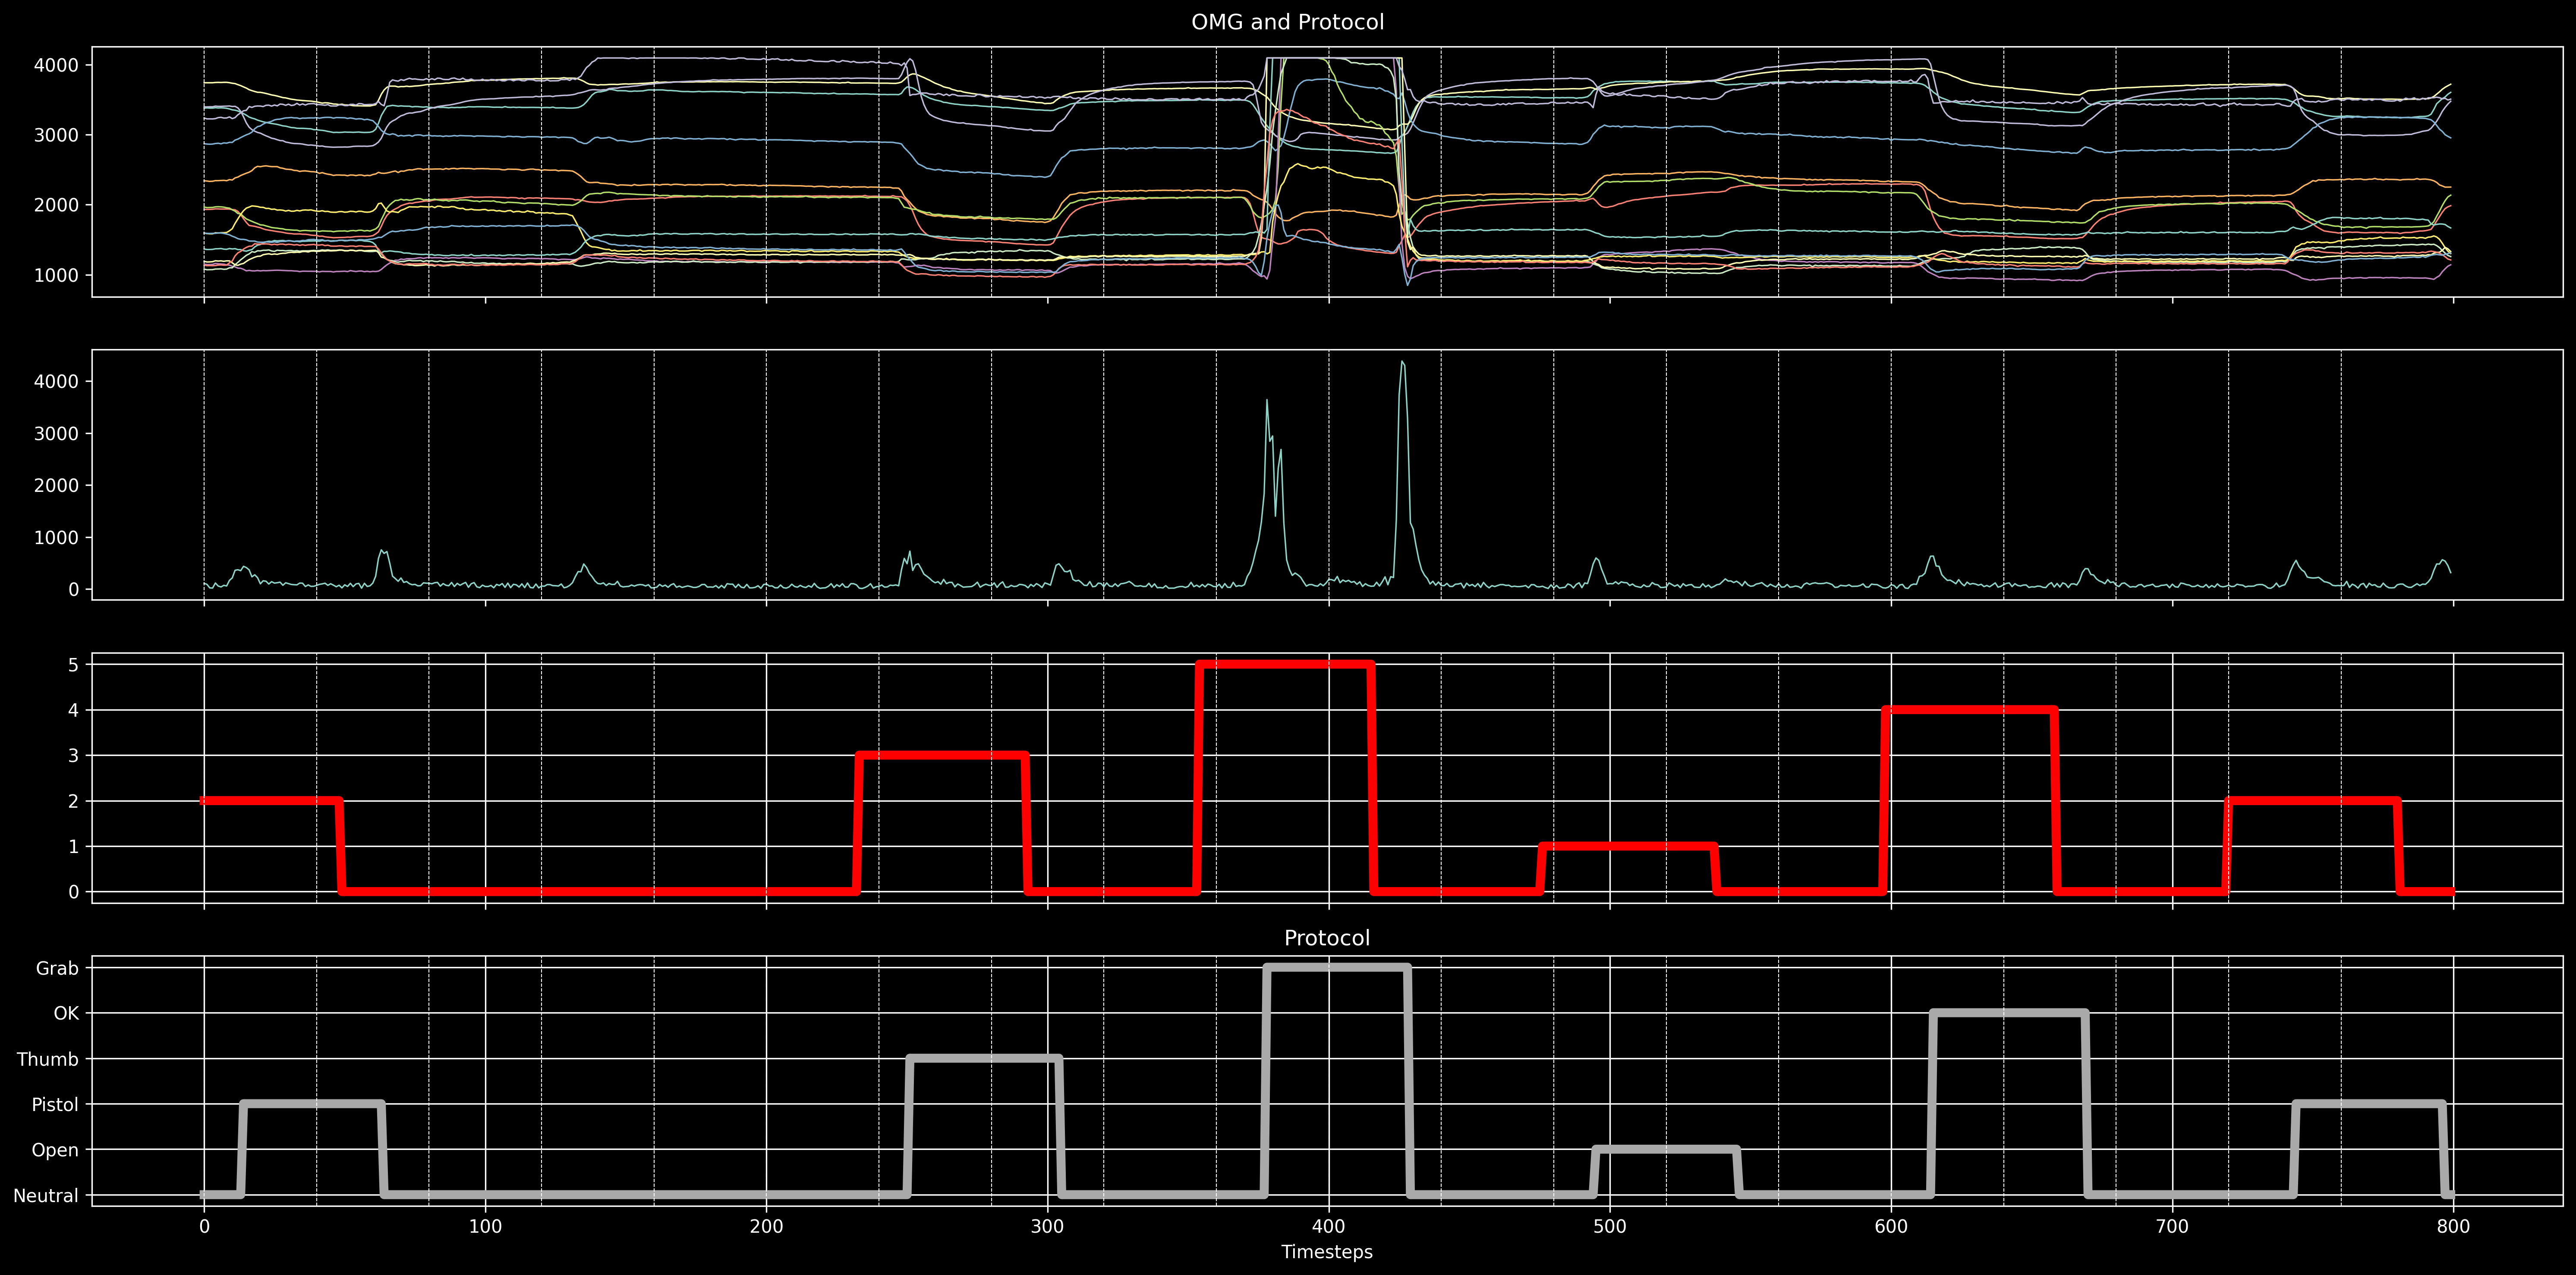

In [17]:
processor.graph_sensor_gestures(range(500, 1300),2)

### Подбор гипперпараметров

Теперь попытаемся подобрать лучший набор параметров для модели Random Forest

In [11]:

def objective(trial):
    # Предлагаем значения гиперпараметров
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
    
    # Инициализируем модель с текущими гиперпараметрами
    model = RandomForestClassifier(**rf_params)
    
    # Оцениваем модель с помощью кросс-валидации
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted').mean()
    
    return score

# Настраиваем исследование с Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Выводим результаты
print("Лучшие гиперпараметры: ", study.best_params)
print("Лучший результат: ", study.best_value)



[I 2024-10-09 19:09:36,097] A new study created in memory with name: no-name-cf2b00a0-e29d-4b46-8c43-361136c63da1
[I 2024-10-09 19:09:44,569] Trial 0 finished with value: 0.9737135732875416 and parameters: {'n_estimators': 76, 'max_depth': 84, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9737135732875416.
[I 2024-10-09 19:09:52,632] Trial 1 finished with value: 0.9726065255267252 and parameters: {'n_estimators': 74, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.9737135732875416.
[I 2024-10-09 19:09:54,809] Trial 2 finished with value: 0.9705969448911014 and parameters: {'n_estimators': 20, 'max_depth': 75, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.9737135732875416.
[I 2024-10-09 19:10:12,532] Trial 3 finished with value: 0.9717486561836073 and parameters: {'n_estimators': 167, 'max_depth': 78, 'min

Лучшие гиперпараметры:  {'n_estimators': 140, 'max_depth': 97, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Лучший результат:  0.9789905801426252


### Построим модель Random Forest на найденных лучших параметрах 

In [12]:
model = RandomForestClassifier(**study.best_params)
model.fit(X = X_train, y=y_train)

RandomForestClassifier(max_depth=97, n_estimators=140)

### Сделаем предсказание

In [13]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_train_init = model.predict(X_init)

### Построим график реальной и предсказанной целевой величины на всем датасете

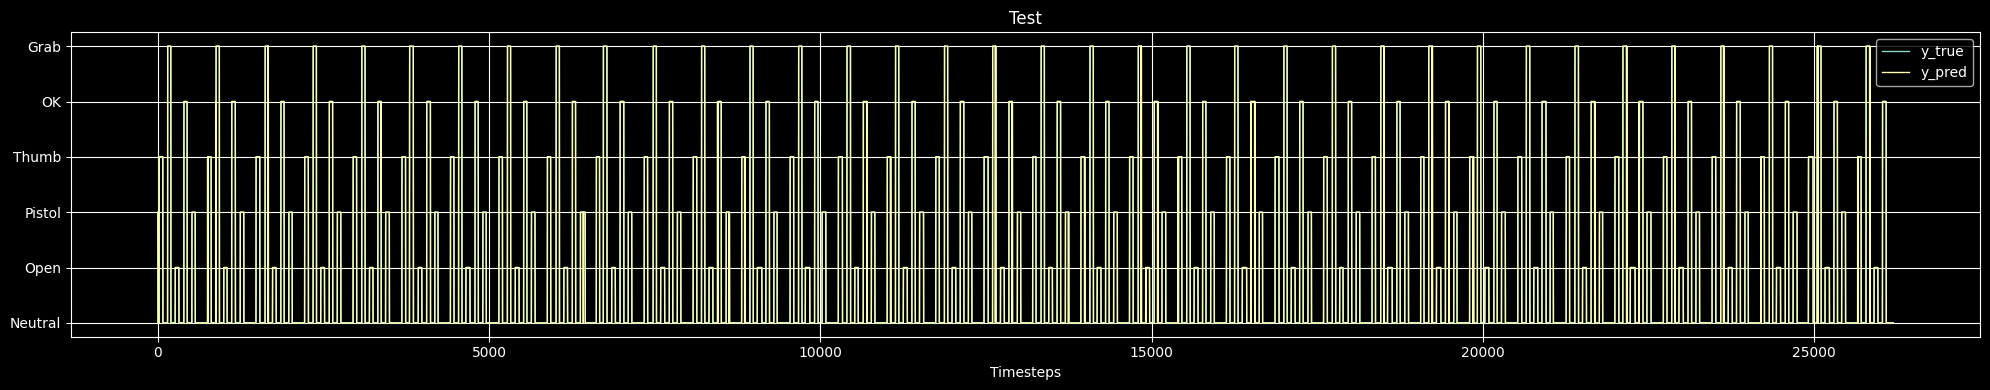

In [14]:
processor.plot_results(y, y_pred_train_init, (20,4), 1)

### Запишем полученные данные статистики в файл статистики

In [15]:

processor.get_statistic(y_train, y_pred_train,1, False)
processor.get_statistic(y_test, y_pred_test,2, False)
processor.get_statistic(y, y_pred_train_init,3, False)

model_parameters = processor.get_params()
model_parameters['model_params'] = study.best_params
model_parameters['model'] = 'rf'
processor.save_stat('st.json', model_parameters)


Новый объект добавлен успешно.


### Перечитаем файл статистики, чтобы узнать id последней записи

In [16]:
stat = processor.get_stat('st.json')
last_rf_idx = stat.iloc[-1].name
last_rf_idx

253

In [17]:
processor.get_statistic_by_id(pd.read_json('st.json'),max_rf)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      0.992     0.976     0.989      0.998     0.989     0.997   
Open         0.999     1.000     1.000      0.990     0.958     0.984   
Pistol       0.999     0.981     0.996      0.987     0.968     0.983   
Thumb        0.994     0.980     0.991      0.982     0.952     0.975   
OK           0.998     0.970     0.993      0.988     0.944     0.979   
Grab         0.996     0.959     0.988      0.989     0.959     0.983   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      0.995     0.982     0.993  
Open         0.995     0.979     0.992  
Pistol       0.993     0.974     0.989  
Thumb        0.988     0.966     0.983  
OK           0.993     0.956     0.986  
Grab         0.993     0.959     0.986

In [18]:
processor.get_statistic_by_id(pd.read_json('st.json'),last_rf_idx)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      1.000     0.979     0.996      1.000     0.990     0.998   
Open         1.000     0.992     0.999      1.000     0.965     0.993   
Pistol       1.000     0.986     0.997      1.000     0.973     0.995   
Thumb        1.000     0.978     0.995      1.000     0.960     0.991   
OK           1.000     0.978     0.996      1.000     0.951     0.991   
Grab         1.000     0.969     0.994      1.000     0.959     0.992   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      1.000     0.984     0.997  
Open         1.000     0.979     0.996  
Pistol       1.000     0.980     0.996  
Thumb        1.000     0.969     0.993  
OK           1.000     0.964     0.993  
Grab         1.000     0.964     0.993

In [19]:
last_rf_value = processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)['rf']['max']
print(f'Сравним. Максимально полученное значение для пилота: {pilote_id} \nс подбором признаков -              {max_rf_value} \nс подбором гиперпараметров модели : {last_rf_value}')

Сравним. Максимально полученное значение для пилота: 4 
с подбором признаков -              0.9834577211611112 
с подбором гиперпараметров модели : 0.9893477194314815


### Замерим inference

In [21]:
df_sim = processor.gestures.iloc[-100:,:-1]
df_sim
processor.inference(model,df_sim)

Среднее время предсказания: 0.007429, что составляет 22.51% от требуемого лимита


Inference для текущей лучшей модели для пилота с id 4 на алгоритме random forest составляет примерно 20% от минимально допустимого порога

## Отбор признаков и первичное обучение модели для пилота с номером 1

Повторим процесс, но уже для пилота с номер 1. Отличие от первого случая, то что мы имеем уже несколько замеров, и данные замеры часто кооринально отличаются друг от друга

In [5]:
pilote_id = 1
# создаем список файлов, котносящихся к указанному пилоту
palm_file = pilot_files[pilot_files.pilote_id == pilote_id].montage.apply(lambda x: './data/'+x).tolist()

In [6]:
# Создаем обьект на основе класса ProstheticHandDataProcessor
processor = ProstheticHandDataProcessor(
                              palm_file, # Список файлов с данными
                              pilote_id = pilote_id,# id пилота 
                              n_omg_channels=50, # количество каналов данных в файле
                              n_acc_channels=3, # количество каналов акселометра
                              n_gyr_channels=3, # количество каналов гироскопа
                              n_enc_channels=6, # количество кодированных каналов
                              n_mag_channels=0)

Всего файлов:                            7
Чтение файла значений:                   ./data/2023-05-15_16-16-08.palm
Чтение файла протокола жестов:           ./data/2023-05-15_16-16-08.palm
Количество записей:                      29145
Срезаем с и до:                          393 <> 29120
----------------------------------------------------------------------------------------------------
Чтение файла значений:                   ./data/2023-05-15_17-12-24.palm
Чтение файла протокола жестов:           ./data/2023-05-15_17-12-24.palm
Количество записей:                      29137
Срезаем с и до:                          395 <> 29109
----------------------------------------------------------------------------------------------------
Чтение файла значений:                   ./data/2023-06-05_16-12-38.palm
Чтение файла протокола жестов:           ./data/2023-06-05_16-12-38.palm
Количество записей:                      22368
Срезаем с и до:                          292 <> 22356
--------------

In [7]:
processor.vectors_cousine()
steps = processor.get_cosine_steps(15)[:-3]
steps

Создание словаря с векторами в формате [сенсор][жест][шаг][значения], доступен через <object>.vectors 
Расчет косинусного сходства между векторами, сгруппированными по сенсорам, доступны через <object>.vectors_sum 
Создадим дополнительные признаки, путем ссумирования подряд по 5 сенсоров
Доступны через <object>.additional_features_1
 
Создадим векторы на базе additional_features_1 и интерполируем их
Доступны через <object>.additional_features_1_vector
 
Рассчитаем косинусную схожесть на векторе additional_features_1_vector
Доступны через <object>.additional_features_1_cosine_mean
 


[0.9120702121075993,
 0.9895843736520528,
 0.9950992339924574,
 0.9959380873967143,
 0.9965853410359988,
 0.9970840535654041,
 0.9970934715906201,
 0.9975525279710814,
 0.9980473819915122,
 0.9984021527609712,
 0.9985172446808954,
 0.9987593636118811]

In [10]:
selection_params = {
    'cosine' : 0,
    'sensor_power' : 25,
    'cosine_add_feature_1' : .9962329743225542,
    'shift' : (0,0)
}

lgb_params = {
    'n_estimators' : 1000,         # Количество деревьев
    'learning_rate' : 0.02,         # Скорость обучения
    'max_depth' : -1,              # Максимальная глубина деревьев (по умолчанию нет ограничений)
    'min_child_samples' : 20,      # Минимальное число образцов в листьях
    'subsample' : 0.8,             # Доля выборки для обучения каждого дерева
    'random_state' : 42            # Для воспроизводимости
}

rf_params = {
    'n_estimators': 50,          # Количество деревьев
    'max_depth': 40,             # Ограничение глубины деревьев
    'min_samples_split': 5,      # Минимум 5 выборок для разделения
    'min_samples_leaf': 3,       # Минимум 3 выборки в листе
    'max_features': 'log2',      # Количество признаков для каждого разделения
    'random_state': 42
}

model_types = {
    'rf' : rf_params,
    'lgb' : lgb_params
}

In [9]:
steps_additional_1 = processor.additional_features_1_cosine_mean
steps_add = sorted(steps_additional_1.values())[-4:]
steps_add

[0.9981144489458443, 0.998300710762998, 0.9993877792884229, 0.999566714947579]

Добавим также в процесс построения модели также lgb алгоритм.

In [14]:
for model_type, model_params in model_types.items():
    for steps_a in steps_add:
        for step in steps:
            selection_params['cosine'] = step
            selection_params['cosine_add_feature_1'] = steps_a
            processor.fit_and_predict(pilote_id, model_type, model_params, selection_params, use_add=False, stat_file = 'st.json' )

        for step in steps:
            selection_params['cosine'] = step
            selection_params['cosine_add_feature_1'] = steps_a
            processor.fit_and_predict(pilote_id, model_type, model_params, selection_params, use_add=True, stat_file = 'st.json' )    

Максимальная сила сигнала: 2851.0
['3', '4', '6', '12', '13', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_6', 'new_feature_7', 'new_feature_8']
Новый объект добавлен успешно.
Максимальная сила сигнала: 2397.0
['3', '6', '12', '13', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_6', 'new_feature_7', 'new_feature_8']
Новый объект добавлен успешно.
Максимальная сила сигнала: 2397.0
['3', '6', '12', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_6', 'new_feature_7', 'new_feature_8']
Новый объект добавлен успешно.
Максимальная сила сигнала: 2397.0
['3', '6', '12', '16', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_6', 'new_feature_7', 'new_feature_8']
Новый объект добавлен успешно.
Максимальная сила сигнала: 2397.0
['3', '6', '12', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_6', 'new_feature_7', 'new_feature_8']
Новый объект добавлен успешно.
Максимальная сила сигнала: 2397

### Просмотрим статистику, полученную в результате обучения моделей с разным набором признаков для Random Forest и LGB для пилота N 1

In [15]:
print(f'''ID пилота: {pilote_id}''')
model_stat = processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)
model_stat

ID пилота: 1


{'lgb': {'min': 0.596999294574074,
  'min_id': 421,
  'max': 0.9732316087611111,
  'max_id': 102},
 'rf': {'min': 0.8384025070592593,
  'min_id': 325,
  'max': 0.9510481419555555,
  'max_id': 91}}

Лучший результат у алгоритма LGB. Статистика данной моеди доступна под id 102


In [16]:
max_lgb_pilote_1 = model_stat['lgb']['max_id']
max_lgb_pilote_value = model_stat['lgb']['max']
processor.get_statistic_by_id(pd.read_json('st.json'),max_lgb_pilote_1)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      1.000     0.945     0.989      1.000     0.973     0.995   
Open         1.000     0.968     0.994      1.000     0.937     0.987   
Pistol       1.000     0.942     0.989      1.000     0.884     0.977   
Thumb        1.000     0.934     0.987      1.000     0.881     0.976   
OK           1.000     0.950     0.990      1.000     0.903     0.980   
Grab         1.000     0.958     0.992      1.000     0.921     0.985   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      1.000     0.959     0.992  
Open         1.000     0.952     0.991  
Pistol       1.000     0.912     0.983  
Thumb        1.000     0.907     0.982  
OK           1.000     0.926     0.985  
Grab         1.000     0.939     0.989

In [17]:
# прочтем файл статистики и сохраним текущий лучший результат пилота 1 и модели на алгоритме LGB
stat = processor.get_stat('st.json')
best_model_params_pilote_1_lgb = processor.get_model_params_by_id(stat, max_lgb_pilote_1)
best_params_pilote_1_lgb = processor.get_params_by_id(stat, max_lgb_pilote_1)

In [19]:
best_params_pilote_1_lgb

{'cosine': 0.9120702121075991,
 'sensor_power': 25,
 'cosine_add_feature_1': 0.999,
 'use_add': False,
 'shift': <bound method NDFrame.shift of cosine                   0.912
 sensor_power                25
 cosine_add_feature_1     0.999
 use_add                  False
 shift                   [0, 0]
 features_num                15
 features_add_1_num           2
 Name: 102, dtype: object>,
 'features_num': 15,
 'features_add_1_num': 2}

На параметрах лучшей модели воссоздадим данную модель

In [20]:
# Инициализируем основные данные для текущей модели
processor.vectors_cousine()

# Применяем паарметры отбора для данных
processor.change_params_and_apply(best_params_pilote_1_lgb['cosine'],best_params_pilote_1_lgb['sensor_power'],best_params_pilote_1_lgb['cosine_add_feature_1'],(0,0))

# Получаем данные для обучения модели
X,X_init,y = processor.model_data_prepare(best_params_pilote_1_lgb['use_add'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Максимальная сила сигнала: 2851.0
['3', '4', '5', '6', '12', '13', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_7', 'new_feature_8']


Посмотрим графчески на входные сигналы сенсоров по данному пилоту N 1

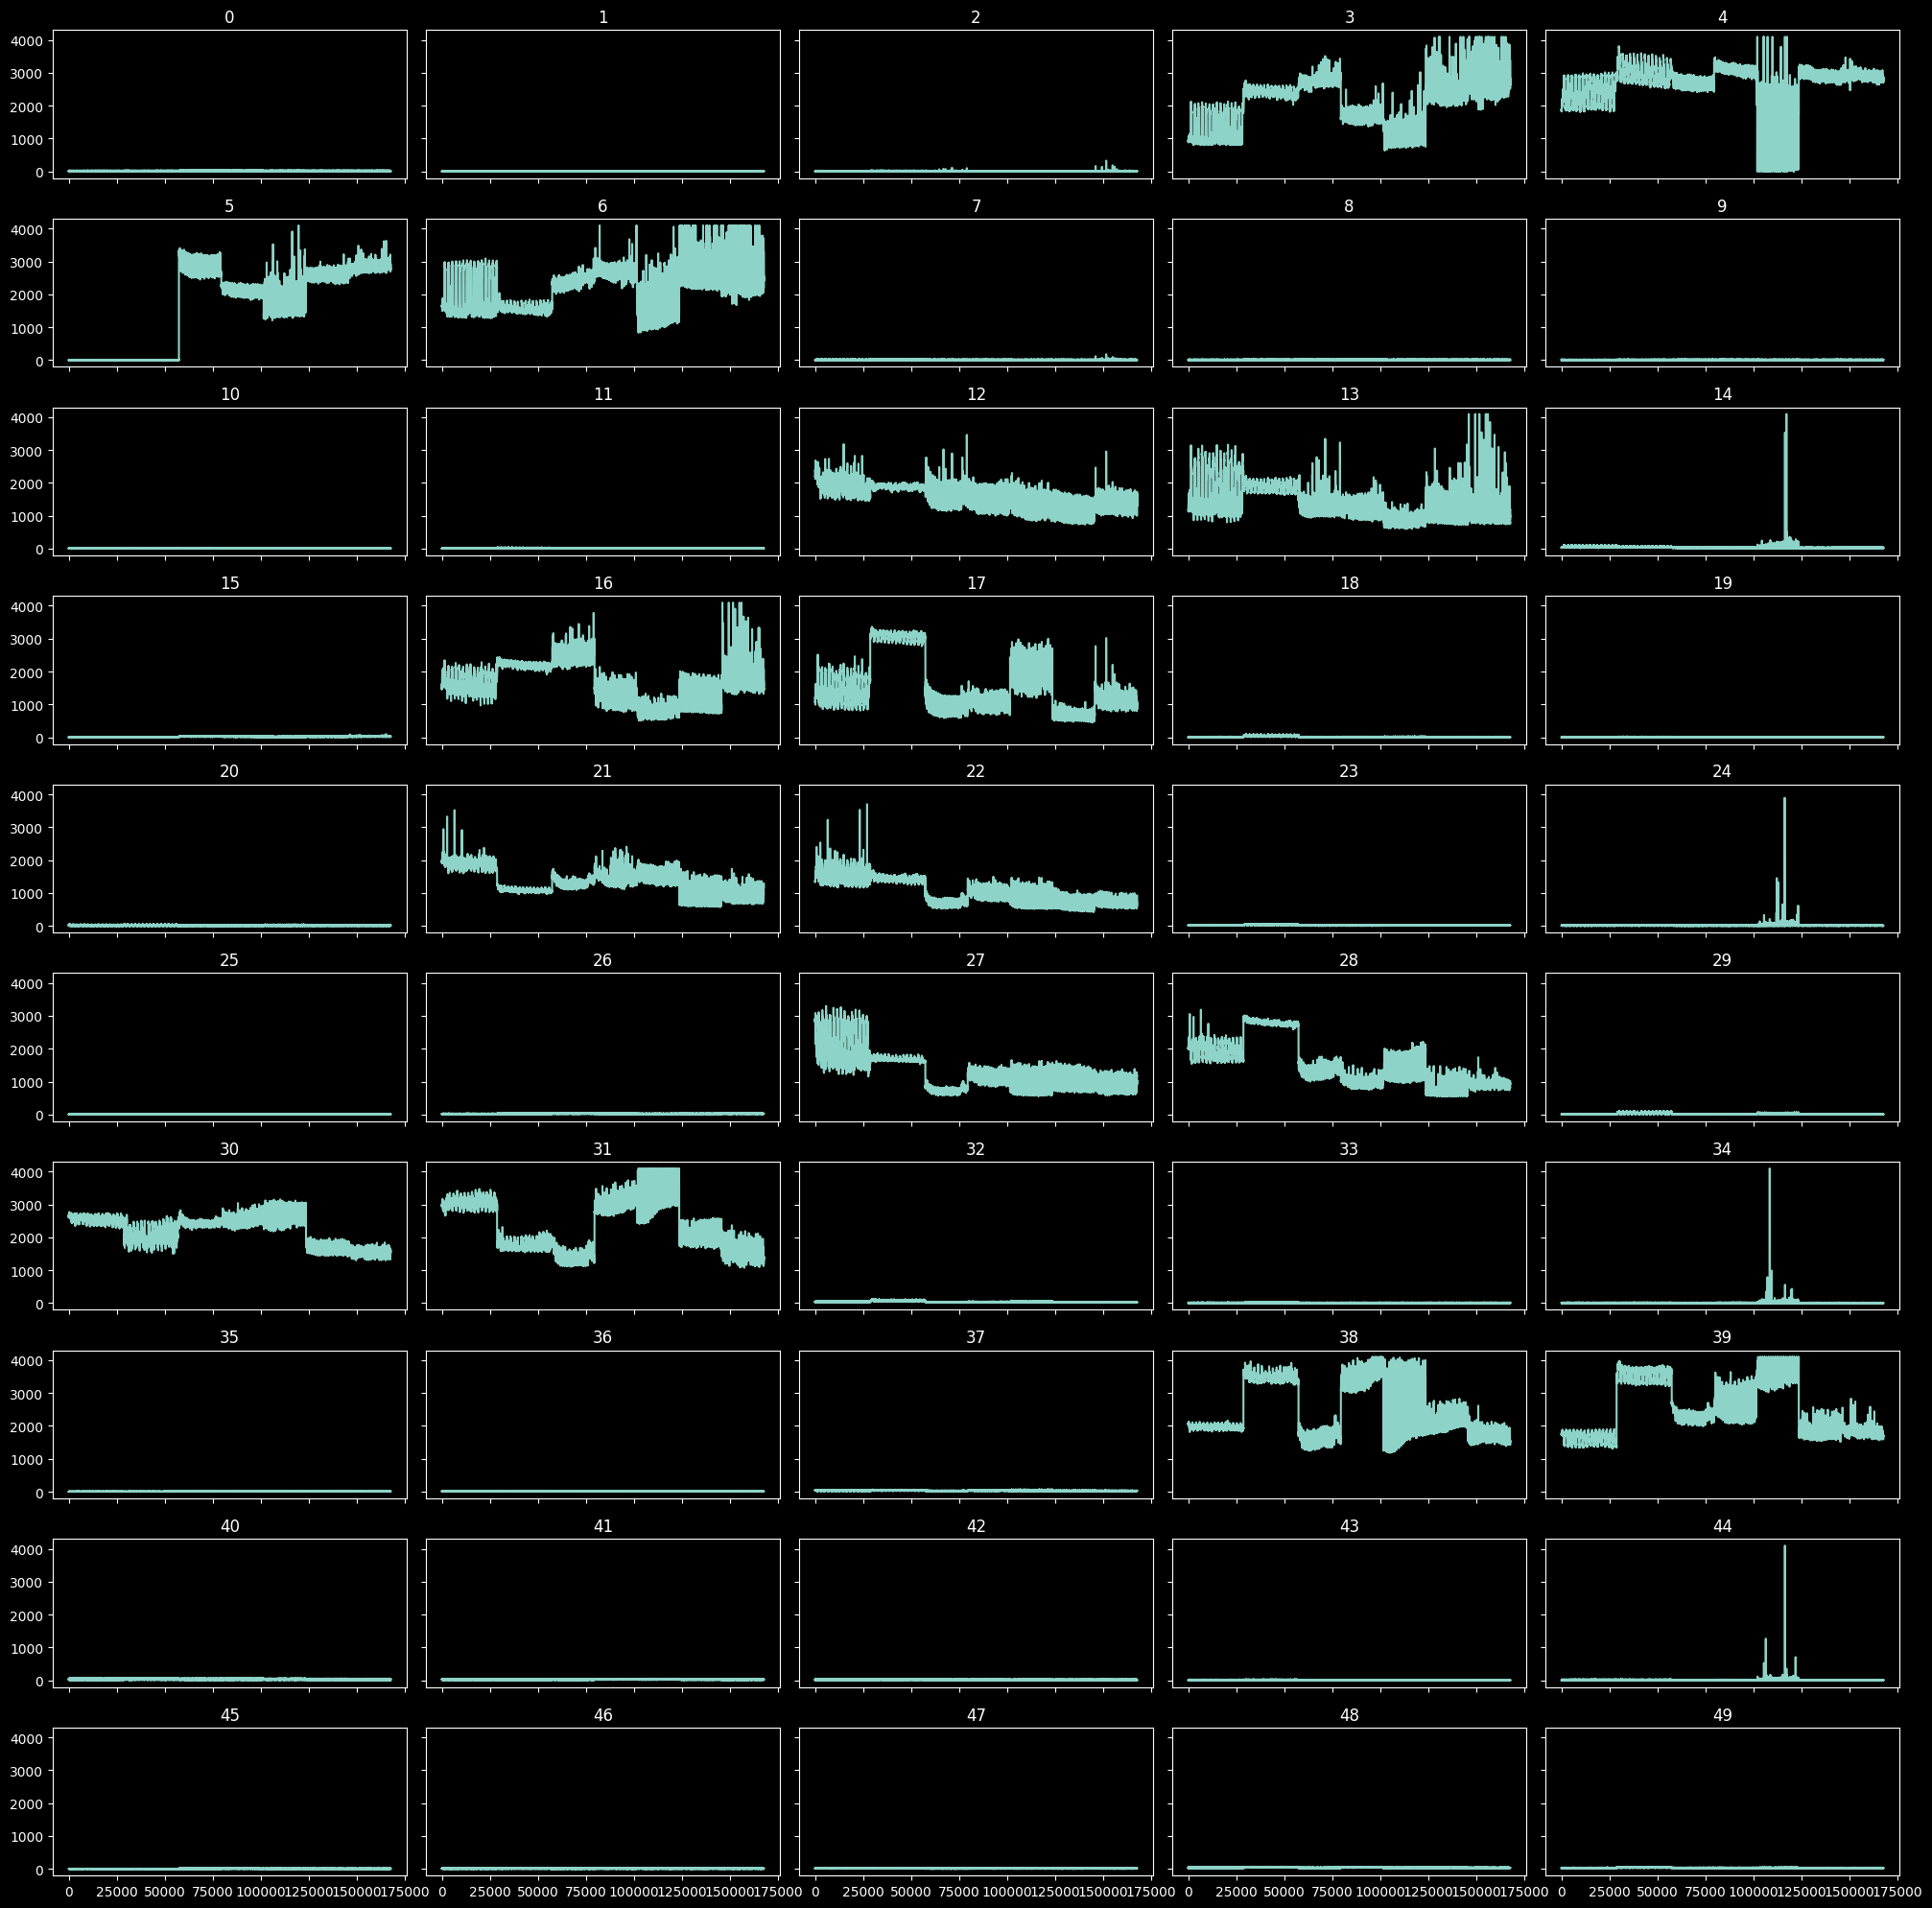

In [21]:
processor.plot_sensors(processor.OMG_CH, range(processor.gestures.shape[0]))

И на график отобранных признаков

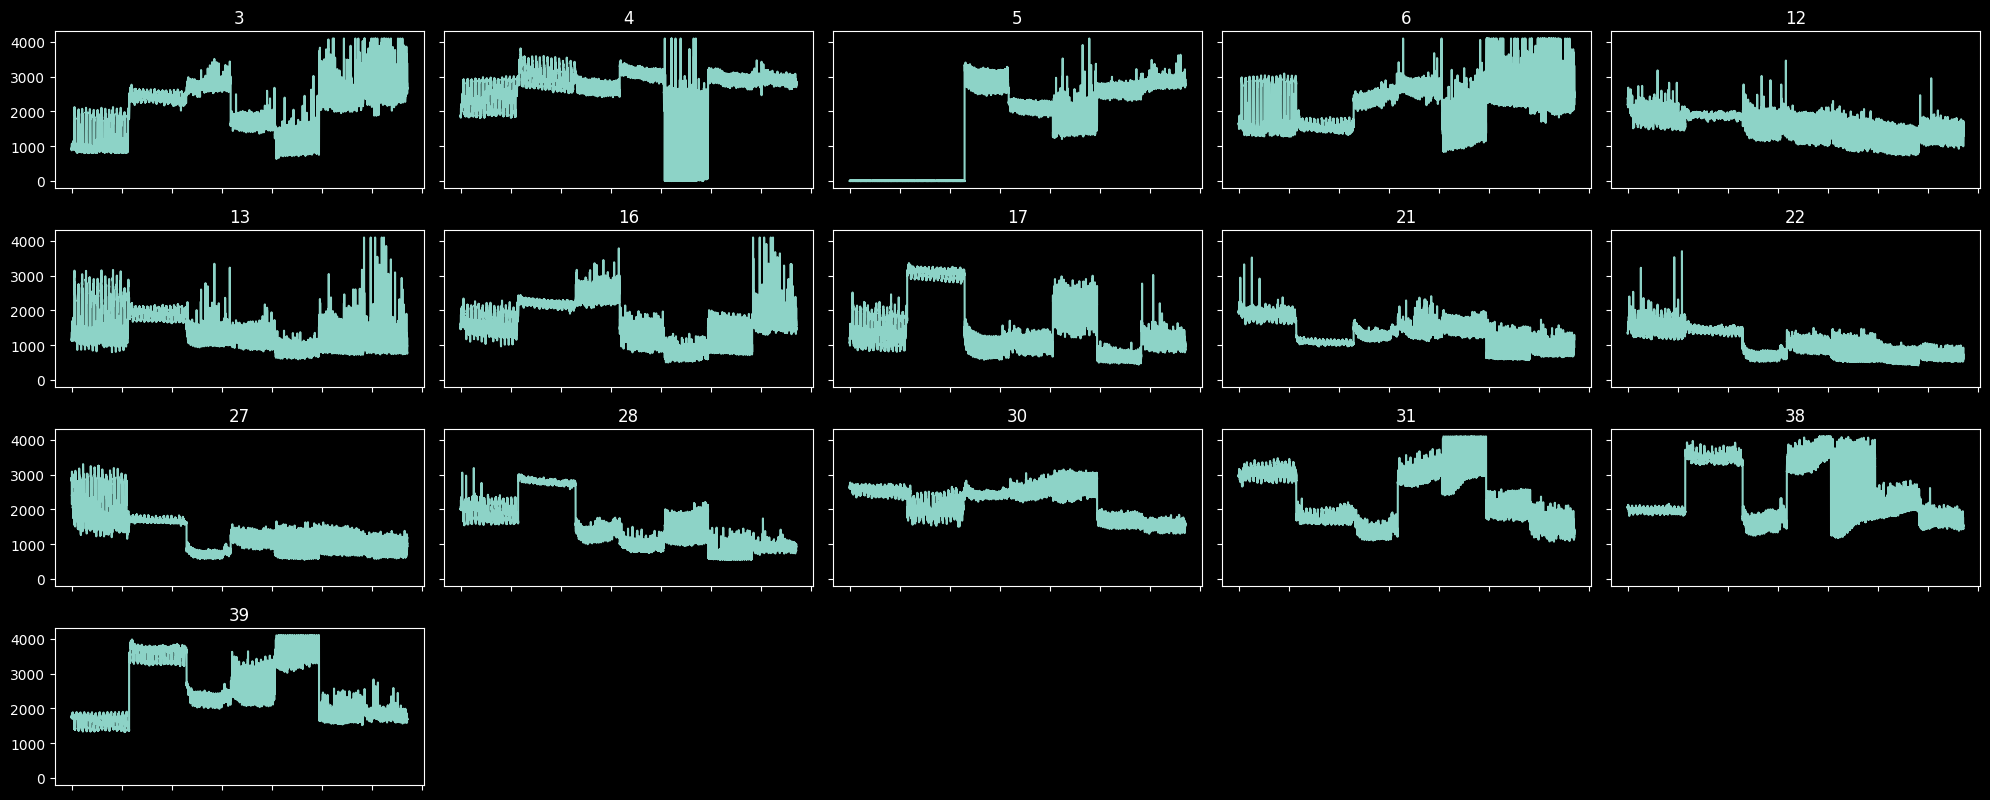

In [23]:
processor.plot_sensors(processor.CLEAN_SENSORS_FINAL, range(processor.gestures.shape[0]))

И также график выполнения смещения для начала и окончания жестов

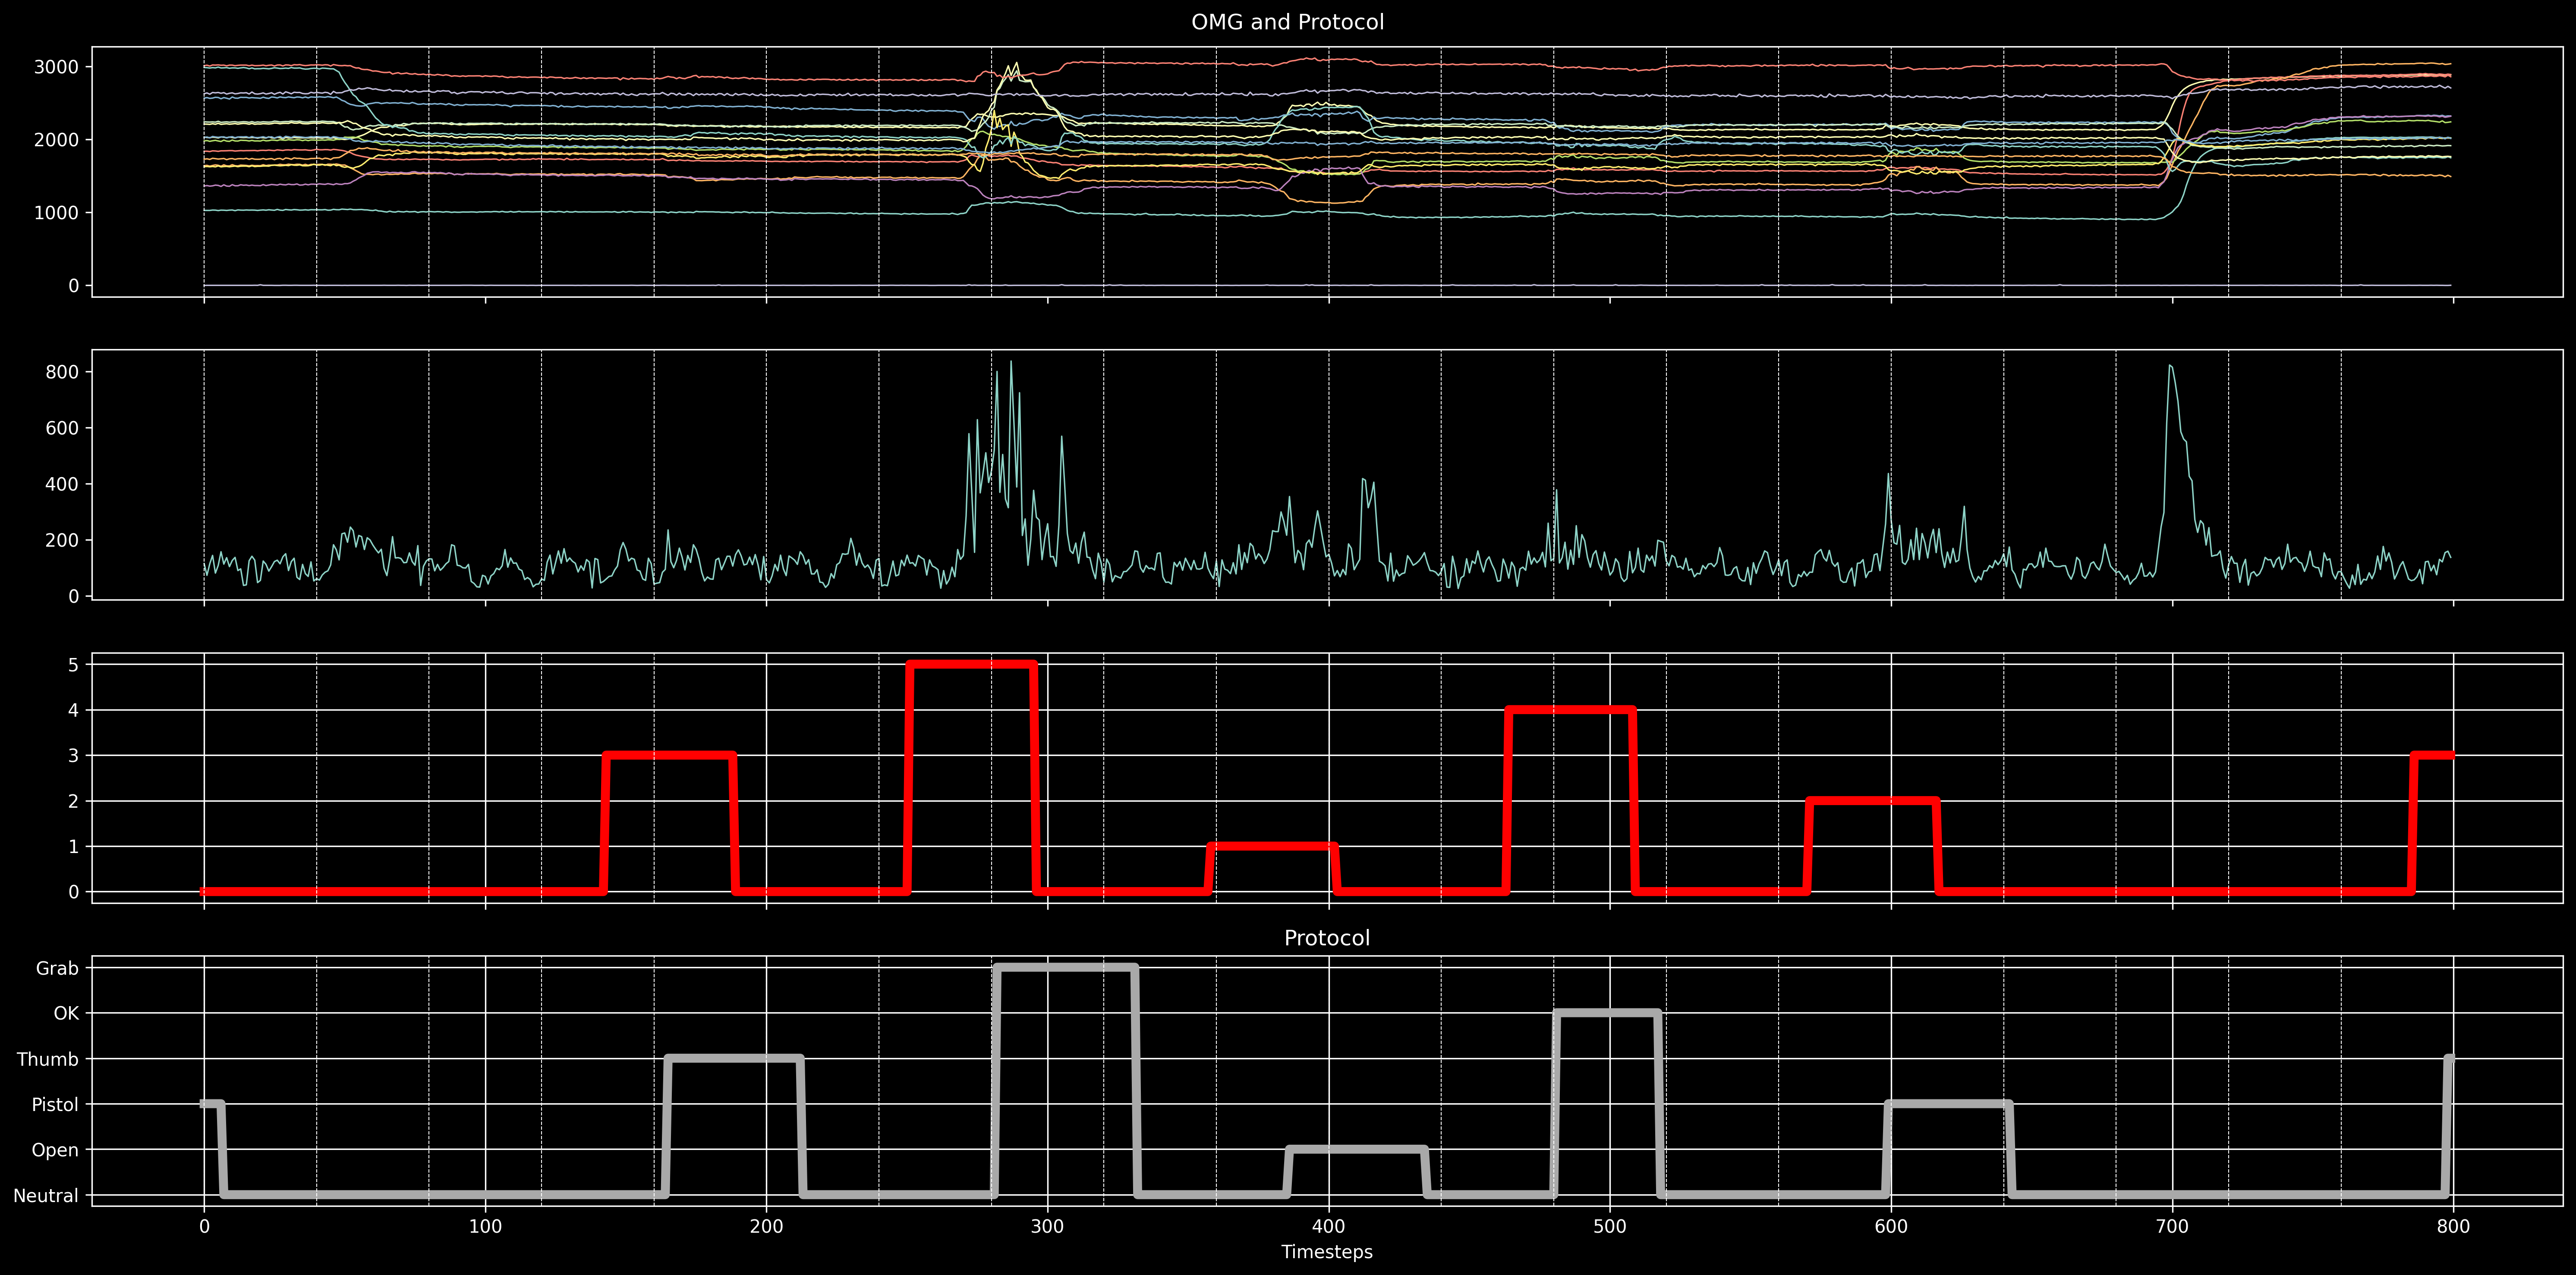

In [24]:
processor.graph_sensor_gestures(range(500, 1300),2)

Теперь подберем гипперпараметры для модели

In [27]:
def objective(trial):
    # Предлагаем значения гиперпараметров
    lgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 2000),
        # 'max_depth': trial.suggest_int('max_depth', 1, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log = True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'random_state': 42
    }
    
    # Инициализируем модель с текущими гиперпараметрами
    model = lgb.LGBMClassifier(**lgb_params)
    
    # Оцениваем модель с помощью кросс-валидации
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted').mean()
    
    return score

# Настраиваем исследование с Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Выводим результаты
print("Лучшие гиперпараметры: ", study.best_params)
print("Лучший результат: ", study.best_value)


[I 2024-10-14 17:51:06,216] A new study created in memory with name: no-name-c3b3c3bf-7097-4c65-b27a-a9e2fef6b9d6
[I 2024-10-14 17:53:15,570] Trial 0 finished with value: 0.938423320407549 and parameters: {'n_estimators': 1401, 'learning_rate': 0.08204744120634284, 'num_leaves': 87, 'min_child_samples': 4}. Best is trial 0 with value: 0.938423320407549.
[I 2024-10-14 17:53:25,076] Trial 1 finished with value: 0.47545113793158617 and parameters: {'n_estimators': 144, 'learning_rate': 0.0015719153772633615, 'num_leaves': 28, 'min_child_samples': 10}. Best is trial 0 with value: 0.938423320407549.
[I 2024-10-14 17:55:00,233] Trial 2 finished with value: 0.8840608613474902 and parameters: {'n_estimators': 1030, 'learning_rate': 0.011323586967195935, 'num_leaves': 69, 'min_child_samples': 8}. Best is trial 0 with value: 0.938423320407549.
[I 2024-10-14 17:55:24,762] Trial 3 finished with value: 0.48405948052594444 and parameters: {'n_estimators': 833, 'learning_rate': 0.8224246455904521, 'n

Лучшие гиперпараметры:  {'n_estimators': 1945, 'learning_rate': 0.1688233661948305, 'num_leaves': 80, 'min_child_samples': 7}
Лучший результат:  0.9407064906612218


Построим модель на подобранных лучших параметрах

In [28]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X = X_train, y=y_train)

LGBMClassifier(learning_rate=0.1688233661948305, min_child_samples=7,
               n_estimators=1945, num_leaves=80)

Сделаем предсказание

In [29]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_train_init = model.predict(X_init)

Отобразим на графике

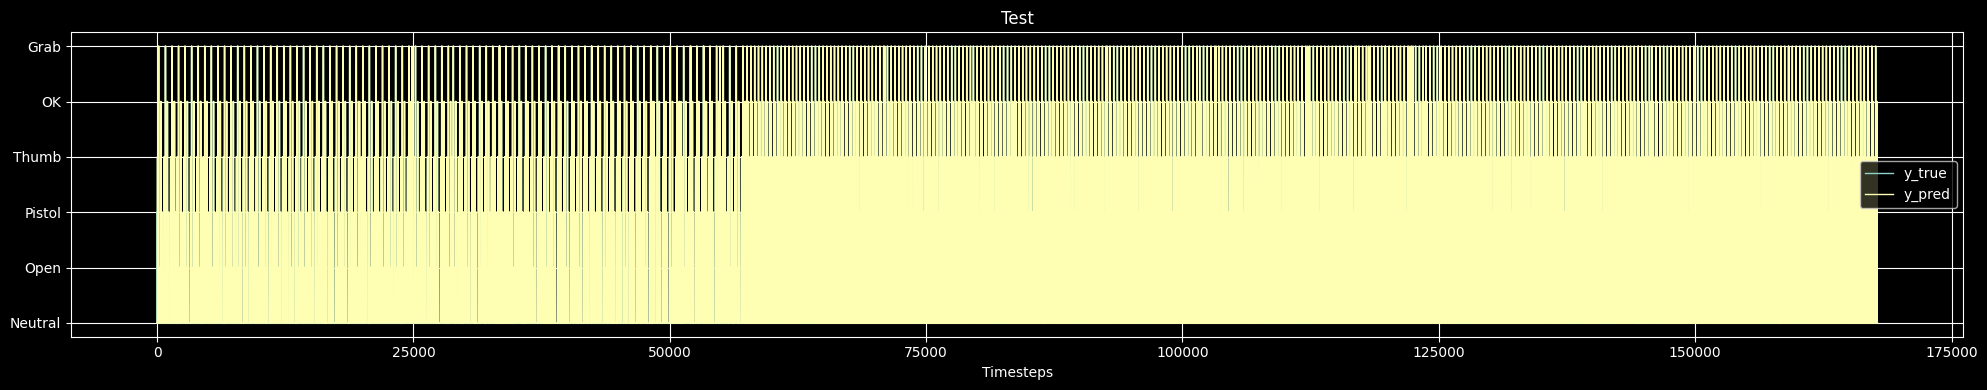

In [30]:
processor.plot_results(y, y_pred_train_init, (20,4), 1)

Запишем полученные данные в файл статистики

In [31]:
processor.get_statistic(y_train, y_pred_train,1, False)
processor.get_statistic(y_test, y_pred_test,2, False)
processor.get_statistic(y, y_pred_train_init,3, False)

model_parameters = processor.get_params()
model_parameters['model_params'] = study.best_params
model_parameters['model'] = 'lgb'
processor.save_stat('st.json', model_parameters)

Новый объект добавлен успешно.


Перечитаем файл статистики и получим id последней записи, т.е наши последние данные статистики для модели на базе LGB после Optuna

In [32]:
stat = processor.get_stat('st.json')
last_rf_idx = stat.iloc[-1].name
last_rf_idx

446

Лучшая модель для пилота N1 с подбором признаков

In [33]:
processor.get_statistic_by_id(pd.read_json('st.json'),max_lgb_pilote_1)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      1.000     0.945     0.989      1.000     0.973     0.995   
Open         1.000     0.968     0.994      1.000     0.937     0.987   
Pistol       1.000     0.942     0.989      1.000     0.884     0.977   
Thumb        1.000     0.934     0.987      1.000     0.881     0.976   
OK           1.000     0.950     0.990      1.000     0.903     0.980   
Grab         1.000     0.958     0.992      1.000     0.921     0.985   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      1.000     0.959     0.992  
Open         1.000     0.952     0.991  
Pistol       1.000     0.912     0.983  
Thumb        1.000     0.907     0.982  
OK           1.000     0.926     0.985  
Grab         1.000     0.939     0.989

Лучшая модель для пилота N1 с подбором признаков с подборкой гиперпараметров

In [34]:
processor.get_statistic_by_id(pd.read_json('st.json'),last_rf_idx)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      1.000     0.954     0.991      1.000     0.973     0.995   
Open         1.000     0.965     0.993      1.000     0.938     0.988   
Pistol       1.000     0.950     0.990      1.000     0.907     0.982   
Thumb        1.000     0.935     0.987      1.000     0.908     0.981   
OK           1.000     0.957     0.992      1.000     0.916     0.983   
Grab         1.000     0.957     0.992      1.000     0.936     0.988   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      1.000     0.964     0.993  
Open         1.000     0.952     0.990  
Pistol       1.000     0.928     0.986  
Thumb        1.000     0.921     0.984  
OK           1.000     0.936     0.987  
Grab         1.000     0.946     0.990

Проверим, удалось ли нам найти более лучшую модель, путоем подбора гипперпараметров

In [36]:
last_lgb_value = processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)['lgb']['max']
print(f'Сравним. Максимально полученное значение для пилота: {pilote_id} \nс подбором признаков -              {max_lgb_pilote_value} \nс подбором гиперпараметров модели : {last_lgb_value}')

Сравним. Максимально полученное значение для пилота: 1 
с подбором признаков -              0.9732316087611111 
с подбором гиперпараметров модели : 0.9765681348259259


Замерим также inference на данной модели на базе алгоритма LGB

In [40]:
processor.CLEAN_SENSORS_ADD_FEATURE_1 = []

In [42]:
df_sim = processor.gestures.iloc[-100:,:-1]
df_sim
processor.inference(model,df_sim)

Среднее время предсказания: 0.007230, что составляет 21.91% от требуемого лимита


### Итоги
- Подход показывает хорошие результаты: на первом шаге выполняется отбор признаков, на втором — гиперпараметризация модели.
- Этот процесс приводит к небольшому, но заметному улучшению качества модели.

Процесс перебора занимает продолжительное время, и я опущу процесс подбора параметров для пилота 2 и 3, так как они и без подбора показывают неплохие результаты. Конечно, в случае с повторением вышепоказанного процесса для пилота 1 и 4, для пилота 2 и 3 также можно найти лучшие модели

In [48]:
pilote_id = 1
print(f'''ID пилота: {pilote_id}''')
model_stat_1 = processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)
model_stat_1

ID пилота: 1


{'lgb': {'min': 0.596999294574074,
  'min_id': 421,
  'max': 0.9765681348259259,
  'max_id': 446},
 'rf': {'min': 0.8384025070592593,
  'min_id': 325,
  'max': 0.9510481419555555,
  'max_id': 91}}

In [49]:
pilote_id = 2
print(f'''ID пилота: {pilote_id}''')
model_stat_2 = processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)
model_stat_2

ID пилота: 2


{'lgb': {'min': 0.7271578797629631,
  'min_id': 20,
  'max': 0.9709563181407407,
  'max_id': 50},
 'rf': {'min': 0.7779700834203704,
  'min_id': 6,
  'max': 0.9468202087296297,
  'max_id': 36}}

In [50]:
pilote_id = 3
print(f'''ID пилота: {pilote_id}''')
model_stat_3 = processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)
model_stat_3

ID пилота: 3


{'lgb': {'min': 0.8953710611648148,
  'min_id': 252,
  'max': 0.9831515563370369,
  'max_id': 241},
 'rf': {'min': 0.9211390661111111,
  'min_id': 240,
  'max': 0.973389860248148,
  'max_id': 230}}

In [51]:
pilote_id = 4
print(f'''ID пилота: {pilote_id}''')
model_stat_4 = processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)
model_stat_4

ID пилота: 4


{'lgb': {'min': 0.9834158850537036,
  'min_id': 217,
  'max': 0.9935855615740742,
  'max_id': 73},
 'rf': {'min': 0.9688166372907409,
  'min_id': 66,
  'max': 0.9893477194314815,
  'max_id': 253}}

* Четко прослеживается тенденция, что во всех случаях модели на базе LGB дают лучше результаты по сравнению с random Forest, но это не очень большая разница, в пределах 1-3%
* inference зависит от кол-ва признаков. В моделях с 15 признаками, это 20-25% от минимального порога. в Моделях с 5-6 признаками, это примерно 10%


In [66]:
pilots_rf = [model_stat_1['rf']['max_id'], model_stat_2['rf']['max_id'], model_stat_3['rf']['max_id'], model_stat_4['rf']['max_id']]
print(f'ID лучших моделей для RF по пилотам: {pilots_rf}')
pilots_lgb = [model_stat_1['lgb']['max_id'], model_stat_2['lgb']['max_id'], model_stat_3['lgb']['max_id'], model_stat_4['lgb']['max_id']]
print(f'ID лучших моделей для LGB по пилотам: {pilots_lgb}')


ID лучших моделей для RF по пилотам: [91, 36, 230, 253]
ID лучших моделей для LGB по пилотам: [446, 50, 241, 73]


In [67]:
stat.loc[pilots_rf][['features_num','clean_sensor_final', 'use_add','clean_sensors_add_feature_1']]

features_num                                 clean_sensor_final  use_add  \
91             14  [3, 6, 12, 13, 16, 17, 21, 22, 27, 28, 30, 31,...     True   
36              9                 [7, 9, 18, 23, 26, 28, 34, 37, 39]     True   
230            14  [3, 4, 5, 6, 12, 13, 16, 17, 22, 27, 28, 30, 3...    False   
253            15  [3, 4, 5, 6, 12, 13, 16, 17, 21, 22, 27, 28, 3...    False   

        clean_sensors_add_feature_1  
91   [new_feature_7, new_feature_8]  
36                  [new_feature_8]  
230                              []  
253                              []

In [68]:
stat.loc[pilots_lgb][['features_num','clean_sensor_final', 'use_add','clean_sensors_add_feature_1']]

features_num                                 clean_sensor_final  use_add  \
446            16  [3, 4, 5, 6, 12, 13, 16, 17, 21, 22, 27, 28, 3...    False   
50              9                 [7, 9, 18, 23, 26, 28, 34, 37, 39]     True   
241            15  [3, 4, 5, 6, 12, 13, 16, 17, 21, 22, 27, 28, 3...    False   
73              8                      [3, 4, 5, 12, 13, 22, 30, 39]    False   

        clean_sensors_add_feature_1  
446  [new_feature_7, new_feature_8]  
50                  [new_feature_8]  
241                              []  
73                               []

## Соберем в одну таблицу F1-Score для полного датасета по каждому из пилотов для Random Forest

In [113]:
pilots_rf_dict = {}
for pilote_idx, pilote in enumerate(pilots_rf,1):
    temp_df = processor.get_statistic_by_id(pd.read_json('st.json'),pilote)
    last_first_level = temp_df.columns.get_level_values(0)[-1]
    pilots_rf_dict[f'Пилот {pilote_idx} RF'] = temp_df.loc[:, last_first_level].iloc[:,-1]

df_rf_f1 = pd.DataFrame(pilots_rf_dict)
df_rf_f1

Пилот 1 RF  Пилот 2 RF  Пилот 3 RF  Пилот 4 RF
Neutral       0.979       0.977       0.989       0.997
Open          0.973       0.948       0.975       0.996
Pistol        0.955       0.956       0.982       0.996
Thumb         0.960       0.949       0.974       0.993
OK            0.960       0.939       0.976       0.993
Grab          0.968       0.971       0.987       0.993

## Соберем в одну таблицу F1-Score для полного датасета по каждому из пилотов для LGB

In [114]:
pilots_lgb_dict = {}
for pilote_idx, pilote in enumerate(pilots_lgb,1):
    temp_df = processor.get_statistic_by_id(pd.read_json('st.json'),pilote)
    last_first_level = temp_df.columns.get_level_values(0)[-1]
    pilots_lgb_dict[f'Пилот {pilote_idx} LGB'] = temp_df.loc[:, last_first_level].iloc[:,-1]
df_lgb_f1 = pd.DataFrame(pilots_lgb_dict)    
df_lgb_f1

Пилот 1 LGB  Пилот 2 LGB  Пилот 3 LGB  Пилот 4 LGB
Neutral        0.993        0.992        0.994        0.998
Open           0.990        0.984        0.990        0.997
Pistol         0.986        0.985        0.993        0.996
Thumb          0.984        0.981        0.979        0.996
OK             0.987        0.976        0.991        0.995
Grab           0.990        0.989        0.995        0.998

## Для удобства сравнения результаты разных алгоритмов, обьединим датасеты в один и счередуем результаты по пилотам

In [117]:
df_combined_f1 = pd.concat([df_rf_f1, df_lgb_f1], axis=1)
df_combined_f1

columns = [col for pair in zip(df_rf_f1.columns, df_lgb_f1.columns) for col in pair]
df_combined_f1 = df_combined_f1[columns]

df_combined_f1

Пилот 1 RF  Пилот 1 LGB  Пилот 2 RF  Пилот 2 LGB  Пилот 3 RF  \
Neutral       0.979        0.993       0.977        0.992       0.989   
Open          0.973        0.990       0.948        0.984       0.975   
Pistol        0.955        0.986       0.956        0.985       0.982   
Thumb         0.960        0.984       0.949        0.981       0.974   
OK            0.960        0.987       0.939        0.976       0.976   
Grab          0.968        0.990       0.971        0.989       0.987   

         Пилот 3 LGB  Пилот 4 RF  Пилот 4 LGB  
Neutral        0.994       0.997        0.998  
Open           0.990       0.996        0.997  
Pistol         0.993       0.996        0.996  
Thumb          0.979       0.993        0.996  
OK             0.991       0.993        0.995  
Grab           0.995       0.993        0.998